# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datasets.

**This time we are going to use a CNN-based autoencoder.**

In [1]:
!pip install -r requirements.txt | grep -v "already"

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=8f92f94d71f3e759952bfe8b347dfe827ad955e7f868afe4ee106a36bd824ad2
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
Successfully built bokeh
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [2]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

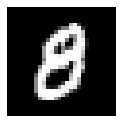

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Convolutional Autoencoder

Write your own CNN autoencoder. Use at least 2 blocks Convolution + ReLU + MaxPooling as _encoder_, and then an equivalent number of upsampling operations (either Transposed Convolutions+ReLU or Upsample+Conv+ReLU) followed by a Sigmoid activation.

In [45]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )
        
#         self.decoder = nn.Sequential(
#             nn.Upsample(scale_factor = 2, mode='nearest'),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Upsample(scale_factor = 2, mode='nearest'),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32, 1, 3, padding=1),
#             nn.Sigmoid()
#         )
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, output_padding=1, padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 3, output_padding=1, padding=1, stride=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        return self.auto_encoder(x)
    
# initialize the NN
model = Autoencoder()

## Loss Function

Set up here a loss function that makes sense for the task at hand (look at the lesson again if you don't remember what this should be):

In [42]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop - however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

Complete the training loop below. As usual, you need to perform the forward and the backward pass.

In [46]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [ ]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        # clear gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass
        output = model(images)
        
        # calculate loss
        loss = criterion(output.flatten(), images.flatten())
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:23<00:00,  1.96s/it]


Epoch: 1 	Training Loss: 41.735467	Valid Loss: 9.947261


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.70s/it]


Epoch: 2 	Training Loss: 7.882648	Valid Loss: 6.124116


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.78s/it]


Epoch: 3 	Training Loss: 5.465625	Valid Loss: 4.751032


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 4 	Training Loss: 4.454174	Valid Loss: 4.040347


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 5 	Training Loss: 4.006246	Valid Loss: 3.651486


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.88s/it]


Epoch: 6 	Training Loss: 3.631624	Valid Loss: 3.405033


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 7 	Training Loss: 3.418609	Valid Loss: 3.275948


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch: 8 	Training Loss: 3.242160	Valid Loss: 3.034245


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


Epoch: 9 	Training Loss: 3.114707	Valid Loss: 3.033670


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 10 	Training Loss: 2.982489	Valid Loss: 2.812569


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it]


Epoch: 11 	Training Loss: 2.900404	Valid Loss: 2.776100


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.88s/it]


Epoch: 12 	Training Loss: 2.818176	Valid Loss: 2.759524


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch: 13 	Training Loss: 2.707746	Valid Loss: 2.653343


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.78s/it]


Epoch: 14 	Training Loss: 2.616460	Valid Loss: 2.507069


Validating: 100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


Epoch: 15 	Training Loss: 2.537115	Valid Loss: 2.556421


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 16 	Training Loss: 2.529716	Valid Loss: 2.419486


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch: 17 	Training Loss: 2.417941	Valid Loss: 2.285178


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 18 	Training Loss: 2.330417	Valid Loss: 2.414067


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 19 	Training Loss: 2.337712	Valid Loss: 2.239103


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch: 20 	Training Loss: 2.278143	Valid Loss: 2.213609


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.92s/it]


Epoch: 21 	Training Loss: 2.263156	Valid Loss: 2.163368


Validating: 100%|██████████| 12/12 [00:19<00:00,  1.63s/it]


Epoch: 22 	Training Loss: 2.174519	Valid Loss: 2.137975


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 23 	Training Loss: 2.137289	Valid Loss: 2.063071


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


Epoch: 24 	Training Loss: 2.113503	Valid Loss: 2.307229


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


Epoch: 25 	Training Loss: 2.127043	Valid Loss: 1.944459


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


Epoch: 26 	Training Loss: 2.032526	Valid Loss: 2.182328


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch: 27 	Training Loss: 2.070936	Valid Loss: 1.930458


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.14s/it]


Epoch: 28 	Training Loss: 1.984759	Valid Loss: 2.014852


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.08s/it]


Epoch: 29 	Training Loss: 1.961963	Valid Loss: 2.015325


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Epoch: 30 	Training Loss: 1.962665	Valid Loss: 1.831790


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.11s/it]


Epoch: 31 	Training Loss: 1.874584	Valid Loss: 1.866496


Validating: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


Epoch: 32 	Training Loss: 1.904931	Valid Loss: 1.845890


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.01s/it]


Epoch: 33 	Training Loss: 1.911299	Valid Loss: 1.830925


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 34 	Training Loss: 1.868252	Valid Loss: 1.769765


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 35 	Training Loss: 1.782274	Valid Loss: 1.755755


Validating: 100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


Epoch: 36 	Training Loss: 1.826841	Valid Loss: 1.790436


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.11s/it]


Epoch: 37 	Training Loss: 1.801477	Valid Loss: 1.698714


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.08s/it]


Epoch: 38 	Training Loss: 1.793211	Valid Loss: 1.739226


Validating: 100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


Epoch: 39 	Training Loss: 1.744861	Valid Loss: 1.706706


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


Epoch: 40 	Training Loss: 1.715934	Valid Loss: 1.727464


Validating: 100%|██████████| 12/12 [00:24<00:00,  2.01s/it]


Epoch: 41 	Training Loss: 1.762255	Valid Loss: 1.701604


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.90s/it]


Epoch: 42 	Training Loss: 1.669922	Valid Loss: 1.595603


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.96s/it]


Epoch: 43 	Training Loss: 1.651996	Valid Loss: 1.590999


Validating: 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Epoch: 44 	Training Loss: 1.719731	Valid Loss: 1.567149


Validating: 100%|██████████| 12/12 [00:26<00:00,  2.18s/it]


Epoch: 45 	Training Loss: 1.620783	Valid Loss: 1.635023


Validating: 100%|██████████| 12/12 [00:26<00:00,  2.21s/it]


Epoch: 46 	Training Loss: 1.621460	Valid Loss: 1.607322


Validating: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 47 	Training Loss: 1.598299	Valid Loss: 1.685705


Validating: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


Epoch: 48 	Training Loss: 1.607810	Valid Loss: 1.570356


Training:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# Epoch: 50 	Training Loss: 1.359510	Valid Loss: 1.399772

## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [48]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


,loss,image,reconstructed
0,0.000881,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0018301785, 0.0006497288, 0.0028239929, 0..."
1,0.001287,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0018301767, 0.0008026949, 0.0037333074, 0..."
2,0.000424,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.001830182, 0.0006497295, 0.0028239929, 0...."
3,0.001347,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0018301804, 0.0006497288, 0.0028239791, 0..."
4,0.001086,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0018301804, 0.0006903566, 0.0032984035, 0..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

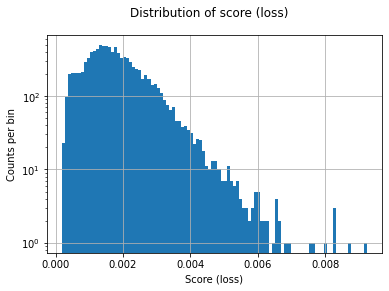

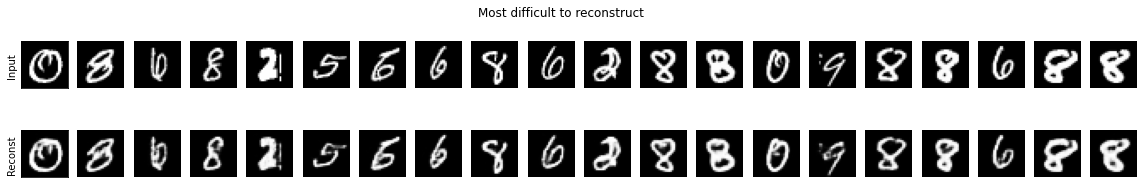

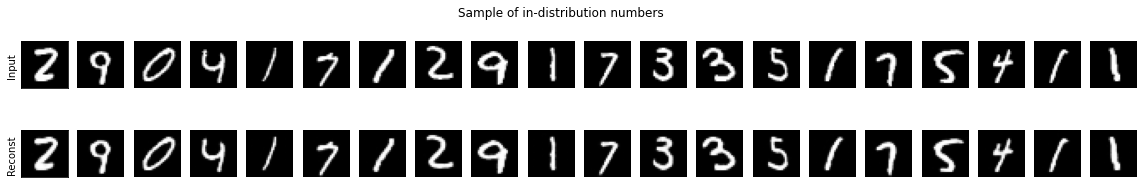

In [49]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

We got similar results as in the case of linear autoencoders, but the loss is on average much smaller (a sign that the network is much more capable of representing and reconstructing the dataset).